In [1]:
# Author: Adam Kleczewski
# License: BSD 3 clause
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.multioutput import ClassifierChain
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import jaccard_score
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier

print(__doc__)


Automatically created module for IPython interactive environment


In [2]:
# Load a multi-label dataset from https://www.openml.org/d/40597
X, Y = fetch_openml('yeast', version=4, return_X_y=True)
Y = Y == 'TRUE'
X = pd.DataFrame(X)
Y = pd.DataFrame(Y)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.2, random_state=0)
X_train = pd.DataFrame(X_train)
Y_train = pd.DataFrame(Y_train)
X_test = pd.DataFrame(X_test)
Y_test = pd.DataFrame(Y_test)


In [3]:
Y_train_sl = pd.DataFrame(Y_train[0])
base_lr = LGBMClassifier()
base_lr.fit(X_train, Y_train_sl)

LGBMClassifier()

In [4]:
# Fit an independent logistic regression model for each class using the
# OneVsRestClassifier wrapper.
base_lr = LGBMClassifier()
ovr = OneVsRestClassifier(base_lr)
ovr.fit(X_train, Y_train)
Y_pred_ovr = ovr.predict(X_test)
Y_pred_proba_ovr = ovr.predict_proba(X_test)
ovr_jaccard_score = jaccard_score(Y_test, Y_pred_ovr, average='samples')



In [5]:
# Fit an ensemble of logistic regression classifier chains and take the
# take the average prediction of all the chains.
chains = [ClassifierChain(base_lr, order='random', random_state=i)
          for i in range(10)]
for chain in chains:
    chain.fit(X_train, Y_train)

Y_pred_chains = np.array([chain.predict(X_test) for chain in
                          chains])
Y_pred_proba_chains = np.array([chain.predict_proba(X_test) for chain in
                          chains])                          
chain_jaccard_scores = [jaccard_score(Y_test, Y_pred_chain >= .5,
                                      average='samples')
                        for Y_pred_chain in Y_pred_chains]

Y_pred_ensemble = Y_pred_chains.mean(axis=0)
ensemble_jaccard_score = jaccard_score(Y_test,
                                       Y_pred_ensemble >= .5,
                                       average='samples')

model_scores = [ovr_jaccard_score] + chain_jaccard_scores
model_scores.append(ensemble_jaccard_score)

model_names = ('Independent',
               'Chain 1',
               'Chain 2',
               'Chain 3',
               'Chain 4',
               'Chain 5',
               'Chain 6',
               'Chain 7',
               'Chain 8',
               'Chain 9',
               'Chain 10',
               'Ensemble')

x_pos = np.arange(len(model_names))


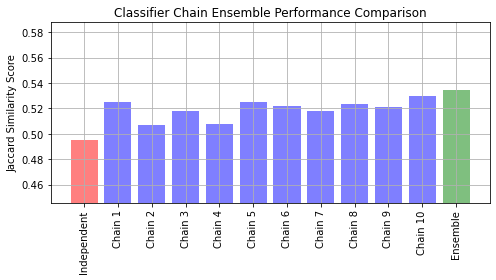

In [6]:
# Plot the Jaccard similarity scores for the independent model, each of the
# chains, and the ensemble (note that the vertical axis on this plot does
# not begin at 0).

fig, ax = plt.subplots(figsize=(7, 4))
ax.grid(True)
ax.set_title('Classifier Chain Ensemble Performance Comparison')
ax.set_xticks(x_pos)
ax.set_xticklabels(model_names, rotation='vertical')
ax.set_ylabel('Jaccard Similarity Score')
ax.set_ylim([min(model_scores) * .9, max(model_scores) * 1.1])
colors = ['r'] + ['b'] * len(chain_jaccard_scores) + ['g']
ax.bar(x_pos, model_scores, alpha=0.5, color=colors)
plt.tight_layout()
plt.show()

# single label에 대한 fitting

In [7]:
base_lr.fit(X_train, pd.DataFrame(Y_train[0]))

LGBMClassifier()

# single label에 대한 predidct_proba 결과 출력

In [8]:
sl_predict_proba = pd.DataFrame(base_lr.predict_proba(X_test)[:, 1])
sl_predict_proba

,0
0,0.238383
1,0.025623
2,0.891434
3,0.966487
4,0.017332
...,...
479,0.532622
480,0.932644
481,0.090738
482,0.014837


# OVR 에 대한 predict_proba 출력. 상기 셀과 동일

In [15]:
pd.DataFrame(Y_pred_proba_ovr[:, 0])

,0
0,0.238383
1,0.025623
2,0.891434
3,0.966487
4,0.017332
...,...
479,0.532622
480,0.932644
481,0.090738
482,0.014837
